Root Mean Squared Error (RMSE): 296.3214593787812
Mean Absolute Error (MAE): 262.44
Mean Absolute Percentage Error (MAPE): 76.86%


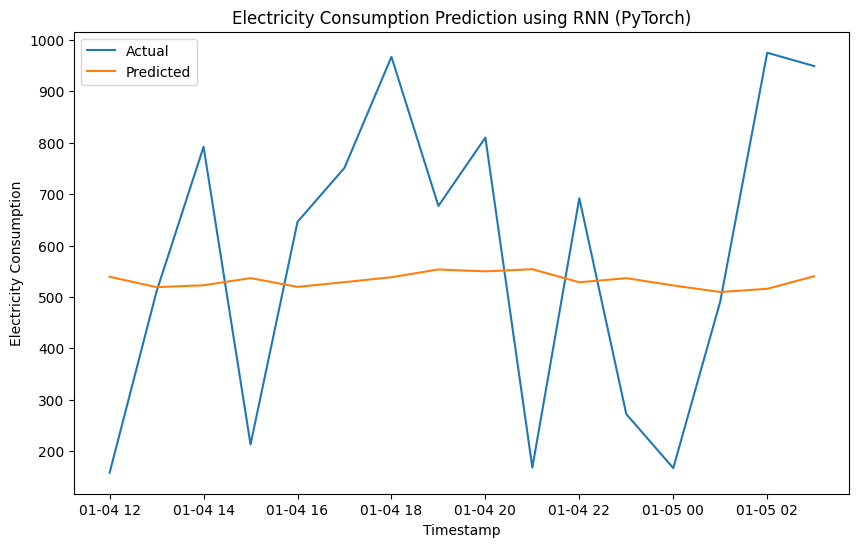

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Sample data for Electricity Consumption
data = {
    'timestamp': pd.date_range(start='2023-01-01', periods=100, freq='H'),
    'consumption': np.random.randint(100, 1000, 100)
}
df = pd.DataFrame(data)
df.set_index('timestamp', inplace=True)

# Preprocessing
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Create sequences and labels for training
seq_length = 24
X, y = [], []
for i in range(len(df_scaled) - seq_length):
    X.append(df_scaled[i:i + seq_length])
    y.append(df_scaled[i + seq_length])


X, y = np.array(X), np.array(y)

# Split the data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create a custom dataset class for PyTorch DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 128
output_size = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# Create data loaders
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # if (epoch + 1) % 10 == 0:
  #      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation on the test set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred = model(X_test_tensor).numpy()
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


# Visualize predictions against actual data
plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size+seq_length:], y_test, label='Actual')
plt.plot(df.index[train_size+seq_length:], y_pred, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption Prediction using RNN (PyTorch)')
plt.legend()
plt.show()